In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

import mplhep as hep
plt.style.use(hep.style.ATLAS)
# plt.rcParams['legend.loc'] = 'upper left'
figsize = (7, 7)

TITLE = r'NVIDIA A10 GPUs, ODD detector, $\mu = 200$, traccc e7a03e9'

In [3]:
def parse_metrics(file_path):
    """Parse metrics from the log file generated by perf_analyzer

    Args:
        file_path (string): Path to the log file

    Returns:
        tuple: A tuple of lists containing the concurrency, 
               throughput, average latency, and standard deviation of latency
    """
    concurrency = []
    throughput = []
    avg_latency = []
    std_latency = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "Request concurrency" in line and "Client" in lines[i + 1]:
                concurrency_value = int(line.split(":")[1].strip())
                concurrency.append(concurrency_value)
                
                throughput_line = lines[i + 3]
                throughput_match = re.search(r"Throughput: ([\d.]+)", throughput_line)
                if throughput_match:
                    throughput_value = float(throughput_match.group(1))
                    throughput.append(throughput_value)
                
                avg_latency_line = lines[i + 4]
                avg_latency_match = re.search(r"Avg latency: (\d+)", avg_latency_line)
                std_latency_match = re.search(r"standard deviation (\d+)", avg_latency_line)
                if avg_latency_match and std_latency_match:
                    avg_latency_value = int(avg_latency_match.group(1))
                    std_latency_value = int(std_latency_match.group(1))
                    avg_latency.append(avg_latency_value)
                    std_latency.append(std_latency_value)

    return concurrency, throughput, np.array(avg_latency)*1e-6, np.array(std_latency)*1e-6

## Example plot of one pass

Uses round-robin load balancing

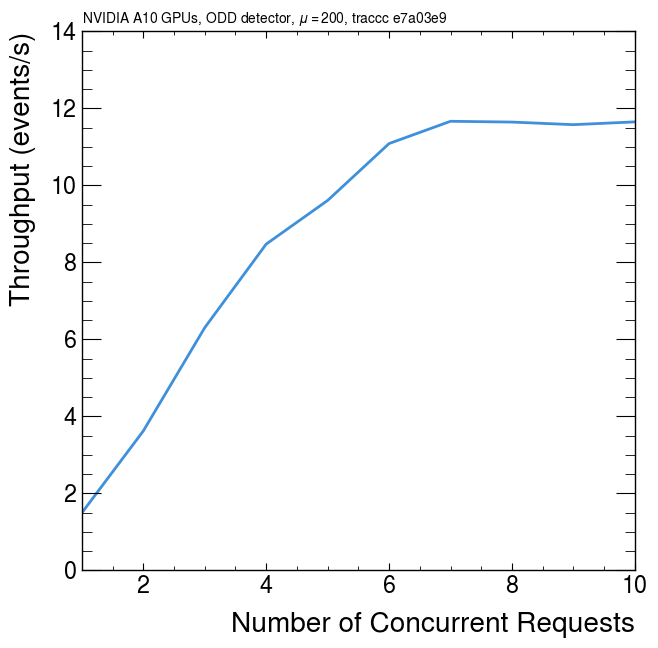

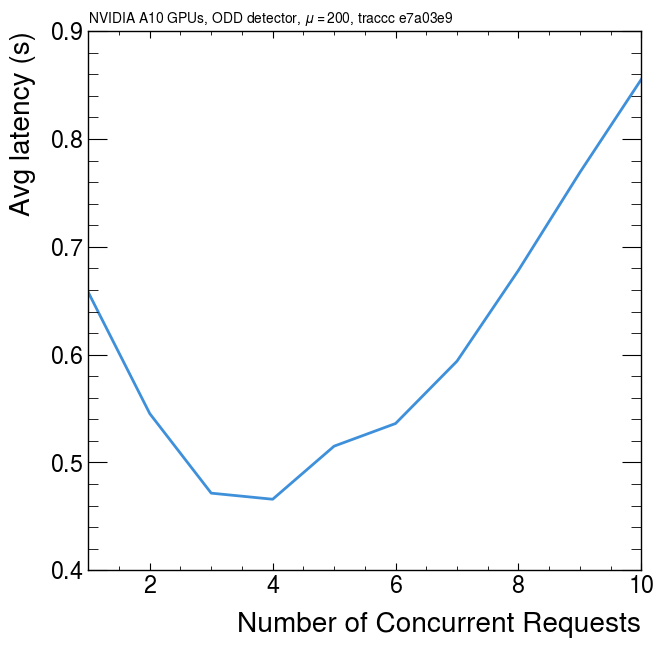

In [4]:
def plot_var(concurrency, data, ylabel, xlabel, filename='', yerr=None):
    fig, ax = plt.subplots(figsize=figsize)
    plt.errorbar(concurrency, data, yerr=yerr)
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')
    plt.xlim(min(concurrency), max(concurrency))
    plt.title(TITLE, fontsize=10, loc='left')
    if filename != '':
        plt.savefig(filename)
    plt.show()
    
path = 'data/nrp_inference_multi_gpu/out4gpu_take9.txt'
con, thr, avg_lat, std_lat = parse_metrics(path)

plot_var(con, thr, 'Throughput (events/s)', 'Number of Concurrent Requests')
plot_var(con, avg_lat, 'Avg latency (s)', 'Number of Concurrent Requests')

### Examples with LEAST_REQUESTS load balancer 

Shows inconsistency between runs as one GPU is potentially favored above the rest

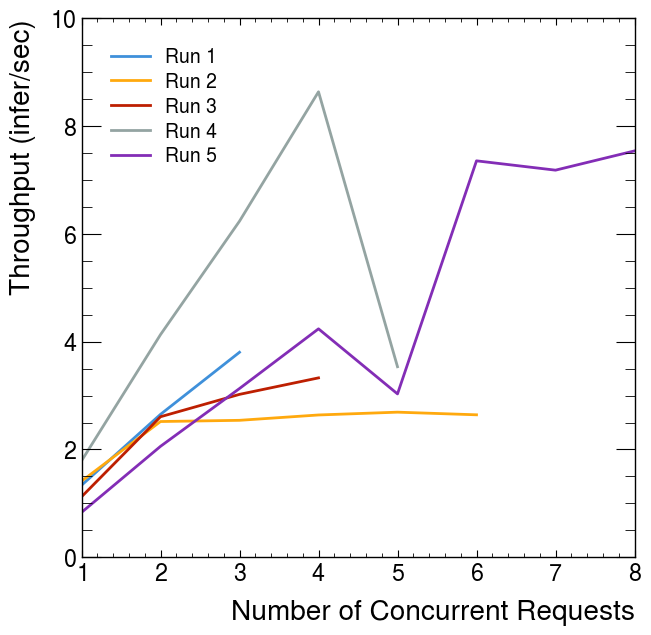

In [6]:
def plot_var_multi_run(concurrency, data, ylabel, xlabel, filename='', yerr=None):
    fig, ax = plt.subplots(figsize=figsize)
    for con, dat in zip(concurrency, data):
        plt.errorbar(con, dat, yerr=yerr, label=f'Run {data.index(dat)+1}')
        plt.legend()
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')
    if filename != '':
        plt.savefig(filename)
    plt.show()

file_path_og = 'data/nrp_inference_multi_gpu/output.txt'
concurrency_og, throughput_og, avg_latency_og, std_avg_latency_og = parse_metrics(file_path_og)

file_path = 'data/nrp_inference_multi_gpu/out4gpu.txt'
concurrency, throughput, avg_latency, std_avg_latency = parse_metrics(file_path)

file_path_run2 = 'data/nrp_inference_multi_gpu/out4gpu_take2.txt'
concurrency_run2, throughput_run2, avg_latency_run2, std_avg_latency_run2 = parse_metrics(file_path_run2)

file_path_run3 = 'data/nrp_inference_multi_gpu/out4gpu_take3.txt'
concurrency_run3, throughput_run3, avg_latency_run3, std_avg_latency_run3 = parse_metrics(file_path_run3)

file_path_run4 = 'data/nrp_inference_multi_gpu/out4gpu_take5.txt'
concurrency_run4, throughput_run4, avg_latency_run4, std_avg_latency_run4 = parse_metrics(file_path_run4)

plot_var_multi_run([concurrency_og, concurrency, concurrency_run2, concurrency_run3, concurrency_run4], [throughput_og, throughput, throughput_run2, throughput_run3, throughput_run4], 'Throughput (infer/sec)', 'Number of Concurrent Requests')

## Examples with ROUND_ROBIN load balancing 

Here, we take the average of multiple runs to get error bars as well. Results are _much_ more consistent. 

In [8]:
def aggregate_metrics(file_paths):
    """Aggregate metrics from multiple log files

    Args:
        file_paths (list of strings): Array of paths to the log files

    Returns:
        tuple: A tuple of lists containing the unique concurrency values, 
               average throughput, standard deviation of throughput, average latency, 
               and standard deviation of latency
    """
    all_concurrency = []
    all_throughput = []
    all_avg_latency = []
    all_std_latency = []

    for file_path in file_paths:
        concurrency, throughput, avg_latency, std_latency = parse_metrics(file_path)
        all_concurrency.extend(concurrency)
        all_throughput.extend(throughput)
        all_avg_latency.extend(avg_latency)
        all_std_latency.extend(std_latency)

    unique_concurrency = sorted(set(all_concurrency))
    avg_throughput = []
    std_throughput = []
    avg_avg_latency = []
    std_avg_latency = []

    for c in unique_concurrency:
        indices = [i for i, x in enumerate(all_concurrency) if x == c]
        throughput_values = [all_throughput[i] for i in indices]
        avg_latency_values = [all_avg_latency[i] for i in indices]
        std_latency_values = [all_std_latency[i] for i in indices]

        avg_throughput.append(np.mean(throughput_values))
        std_throughput.append(np.std(throughput_values))
        avg_avg_latency.append(np.mean(avg_latency_values))
        std_avg_latency.append(np.std(avg_latency_values))

    return unique_concurrency, avg_throughput, std_throughput, avg_avg_latency, std_avg_latency

In [9]:
# tests 7, 8, 9, 10, 11 are using round robin load balancing and seem to produce consistent results
# must be adjusted for individual use-case
file_paths = [f'data/nrp_inference_multi_gpu/out4gpu_take{i}.txt' for i in range(7, 12)]
unique_concurrency, avg_throughput, std_throughput, avg_avg_latency, std_avg_latency = aggregate_metrics(file_paths)

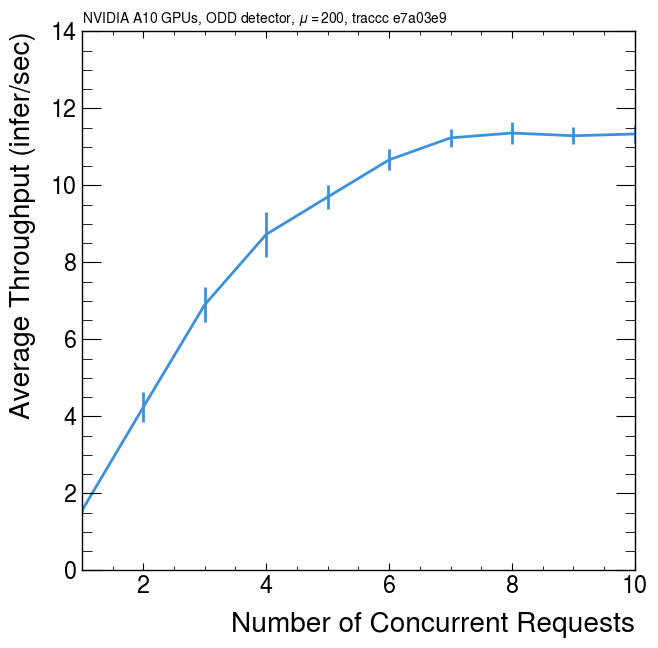

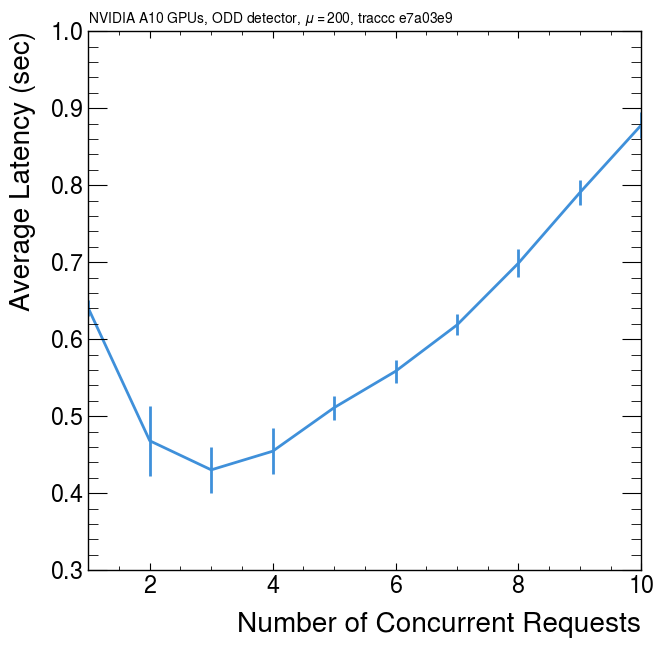

In [10]:
plot_var(unique_concurrency, avg_throughput, 
         'Average Throughput (infer/sec)', 'Number of Concurrent Requests', yerr=std_throughput)
plot_var(unique_concurrency, avg_avg_latency, 
         'Average Latency (sec)', 'Number of Concurrent Requests', yerr=std_avg_latency)

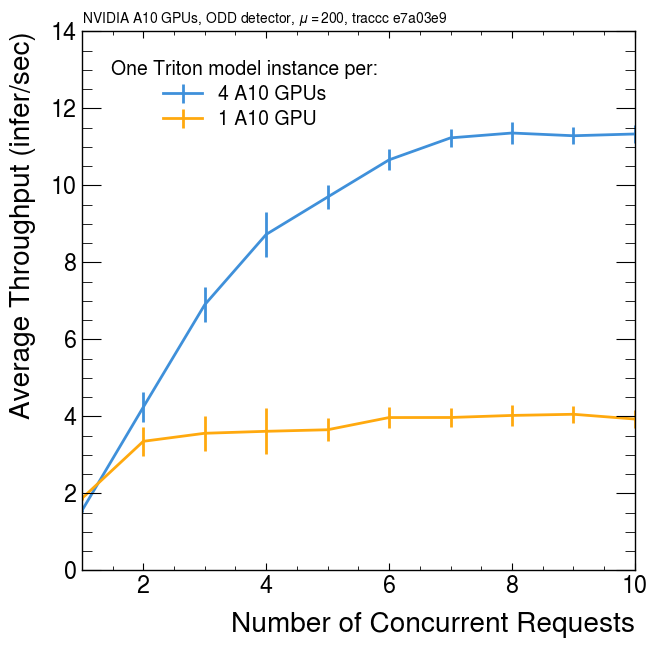

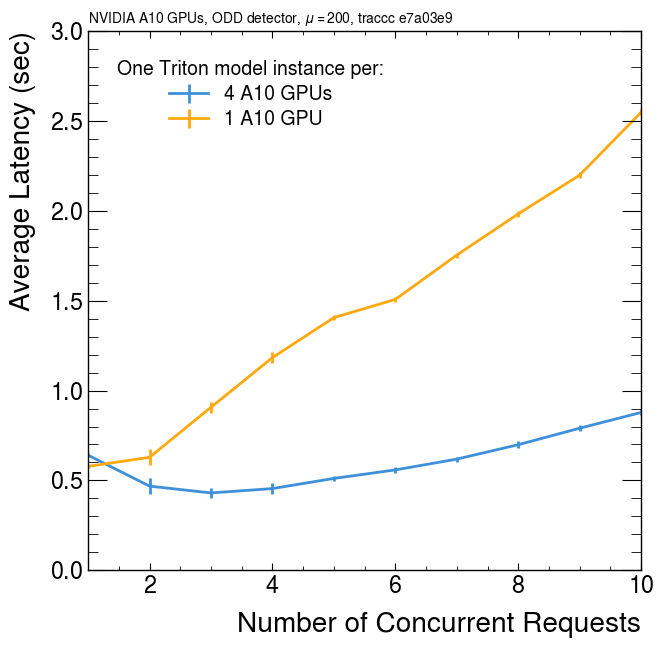

In [11]:
def plot_var_and_compare(concurrency, data, data_1gpu, ylabel, xlabel, filename='', yerr=None):
    fig, ax = plt.subplots(figsize=figsize)
    plt.errorbar(concurrency, data, yerr=yerr, label='4 A10 GPUs')
    plt.errorbar(concurrency, data_1gpu, yerr=yerr, label='1 A10 GPU')
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')
    plt.xlim(min(concurrency), max(concurrency))
    plt.title(TITLE, fontsize=10, loc='left')
    plt.legend(title='One Triton model instance per:')
    if filename != '':
        plt.savefig(filename)
    plt.show()


file_paths_1gpu = [f'data/nrp_inference_multi_gpu/out1gpu_take{i}.txt' for i in range(1, 6)] # run 3 is a tad weird

unique_concurrency_1gpu, avg_throughput_1gpu, std_throughput_1gpu, avg_avg_latency_1gpu, std_avg_latency_1gpu = aggregate_metrics(file_paths_1gpu)

plot_var_and_compare(unique_concurrency, avg_throughput, avg_throughput_1gpu, 
                     'Average Throughput (infer/sec)', 'Number of Concurrent Requests', yerr=std_throughput)

plot_var_and_compare(unique_concurrency, avg_avg_latency, avg_avg_latency_1gpu, 
                     'Average Latency (sec)', 'Number of Concurrent Requests', yerr=std_avg_latency)